In [17]:
import xarray as xr
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import HourLocator
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap,Normalize
import cmocean

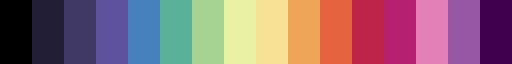

In [18]:
# Load colormap

# Read the colormap from a .txt file
def load_colormap_from_txt(file_path):
    # Load RGB values from the file
    rgb_values = np.loadtxt(file_path)
    return ListedColormap(rgb_values)

# Example usage
colormap_file = 'chase-spectral-rgb.txt'  # Replace with your .txt file path
radar_cmap = load_colormap_from_txt(colormap_file)

discrete_cmap = ListedColormap(radar_cmap(np.linspace(0, 1, 16)))
discrete_mask_cmap = discrete_cmap.copy()
discrete_mask_cmap.set_under(color='white') #set values below vmin to white
discrete_mask_cmap.set_bad(color='gray') #set missing (NaN) values to gray

discrete_mask_cmap

In [2]:
root = "ipfs://QmfAzqPtR99owGURk27JV4Vgwun1CxRpKjomtkBxYufv5b"
dset_meteo = xr.open_dataset(f"{root}/DShip.zarr",engine="zarr")
dset_disdro = xr.open_dataset(
    f"{root}/disdrometer/DSD_METEOR_merged.zarr",engine="zarr")
dset_sea_snake = xr.open_dataset(f"{root}/SeaSnake/met_203_1_SeaSnake.zarr",engine="zarr")
dset_termo = xr.open_dataset(f"{root}/thermosalinograph/met_203_1_tsal.zarr",engine="zarr")
dset_lidart = xr.open_dataset(f"{root}/LICHT-LIDAR_t.zarr",engine="zarr")
dset_lidart_sel = dset_lidart.sel(time= slice('2024-09-08 06 ','2024-09-08 17:00:00'),alt=slice(0,600))
dset_raingauge = xr.open_dataset("ipfs://bafybeigxrptjacw3gwyowbw4d5n3aixp52qlgfhlj2cxdnhofcoxmkgmdi", engine="zarr")

In [3]:
#cloudnet
cloudnet = xr.open_dataset("ipns://latest.orcestra-campaign.org/products/METEOR/cloudnet.zarr", engine="zarr")
cloudnet

<xarray.Dataset> Size: 7GB
Dimensions:                 (time: 106200, height: 393)
Coordinates:
  * height                  (height) float32 2kB 120.3 135.3 ... 1.198e+04
  * time                    (time) datetime64[ns] 850kB 2024-08-17T00:00:15 ....
Data variables: (12/55)
    N_scaled                (time, height) float32 167MB ...
    Tw                      (time, height) float32 167MB ...
    Z                       (time, height) float32 167MB ...
    Z_bias                  (time) float32 425kB ...
    Z_error                 (time, height) float32 167MB ...
    Z_sensitivity           (time, height) float32 167MB ...
    ...                      ...
    rain_detected           (time) float64 850kB ...
    rainfall_rate           (time) float32 425kB ...
    target_classification   (time, height) float64 334MB ...
    v                       (time, height) float32 167MB ...
    v_sigma                 (time, height) float32 167MB ...
    width                   (time, height) float32 167MB ...
Attributes: (12/18)
    Conventions:         CF-1.8
    cloudnet_file_type:  der
    title:               Cloudnet droplet effective radius on RV Meteor durin...
    location:            RV Meteor
    year:                2024
    source:              RPG-Radiometer Physics RPG-FMCW-94\nLufft CHM15k\nEC...
    ...                  ...
    platform:            RV METEOR
    institution:         Leipzig Institute for Meteorology, Leipzig University
    instrument:          Cloudnet product based on cloud radar, ceilometer, m...
    creator_id:          ORCiD: 0000-0002-1164-3576
    keywords:            Cloudnet, effective radius, droplet
    featureType:         trajectoryProfile

In [4]:
#sea_pool_file = '/Users/hans/Documents/bow_tie/SEA-POOL/SEA-POL_gridded_rainrate_spatial_means_masked.nc'
sea_pool_file = '../processed_data/SEA-POL_4b_rainrate_2D_spatial_means_masked_reg10.nc'
dset_pool = xr.open_dataset(sea_pool_file,chunks='auto' )

In [5]:
#sea_pool_qv_file = '/Users/hans/Documents/bow_tie/SEA-POOL/qvp_1D.nc'
sea_pool_qv_file = '/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4b/PICCOLO_level4b_qvp_1D.nc'
dset_pool_qv = xr.open_dataset(sea_pool_qv_file,chunks='auto' )

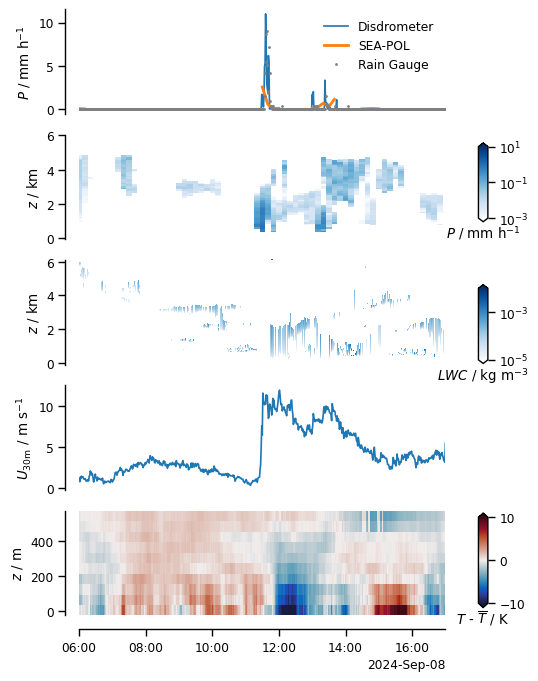

In [37]:
sns.set_context("paper")
fig = plt.figure(figsize=(12/2.54,20/2.54),facecolor='white')
ax1=fig.add_axes([0.97,0.61,0.02,0.10])
ax1a=fig.add_axes([0.97,0.43,0.02,0.10])
ax2=fig.add_axes([0.97,0.12,0.02,0.12])

ax= fig.add_subplot(511)
dset_disdro.rain_rate_qc.sel(
    time=slice('2024-09-08 06:00','2024-09-08 17:00')).plot(label='Disdrometer')
dset_pool.rain1_int.sel(
    time=slice('2024-09-08 06:00','2024-09-08 17:00')).plot(linewidth='2',label='SEA-POL')
dset_raingauge.RR_SRM.sel(
    time=slice('2024-09-08 06:00','2024-09-08 17:00')).plot(
    marker='o',linestyle='',markersize=1,color='gray',label='Rain Gauge')
ax.set_title(None)
ax.set_xlabel(None)
ax.set_xlim([dset_lidart_sel.time[0],dset_lidart_sel.time[-1]])
ax.set_xticks([])
ax.set_xticklabels({})
ax.set_ylabel(r'$P$ / mm h$^{-1}$')
sns.despine(offset=10,ax=ax)
ax.spines['bottom'].set_visible(False)
plt.legend(frameon=False)

ax= fig.add_subplot(512)
rain_cmap=plt.get_cmap('Blues').copy()
rain_cmap.set_under(color='white') #set values below vmin to white
plot_seapool = dset_pool_qv.assign_coords({'Z':dset_pool_qv.Z.values/1000}).RAINRATE.sel(
    time=slice('2024-09-08 06:00','2024-09-08 17:00'),Z=slice(0,6)).plot(
    x='time',cmap=rain_cmap, norm=colors.LogNorm(vmin=0.001,vmax=10),shading='auto',add_colorbar=False)
ax.set_xlim([dset_lidart_sel.time[0],dset_lidart_sel.time[-1]])
sns.despine(offset=10,ax=ax)
ax.set_xticks([])
ax.set_xticklabels({})
ax.spines['bottom'].set_visible(False)
ax.set_ylabel(r'$z$ / km')

## Cloud net liquid water content
#ax= fig.add_subplot(513)
#rain_cmap=plt.get_cmap('Blues').copy()
#rain_cmap.set_under(color='white') #set values below vmin to white
#plot_cloudnet = cloudnet.assign_coords({'height':cloudnet.height.values/1000}).lwc.sel(
#    time=slice('2024-09-08 06:00','2024-09-08 17:00'),height=slice(0,6)).plot(
#    x='time',cmap=rain_cmap, norm=colors.LogNorm(vmin=0.00001,vmax=0.01),shading='auto',add_colorbar=False)
#ax.set_xlim([dset_lidart_sel.time[0],dset_lidart_sel.time[-1]])
#ax.set_ylim([-0.1,6.1])
#sns.despine(offset=10,ax=ax)
#ax.set_xticks([])
#ax.set_xticklabels({})
#ax.spines['bottom'].set_visible(False)
#ax.set_ylabel(r'$z$ / km')

ax= fig.add_subplot(513)
rain_cmap=plt.get_cmap('Blues').copy()
rain_cmap.set_under(color='white') #set values below vmin to white
plot_cloudnet = cloudnet.assign_coords({'height':cloudnet.height.values/1000}).lwc.sel(
    time=slice('2024-09-08 06:00','2024-09-08 17:00'),height=slice(0,6)).plot(
    x='time',cmap=rain_cmap, norm=colors.LogNorm(vmin=0.00001,vmax=0.01),shading='auto',add_colorbar=False)
ax.set_xlim([dset_lidart_sel.time[0],dset_lidart_sel.time[-1]])
ax.set_ylim([-0.1,6.1])
sns.despine(offset=10,ax=ax)
ax.set_xticks([])
ax.set_xticklabels({})
ax.spines['bottom'].set_visible(False)
ax.set_ylabel(r'$z$ / km')

## W-band radar reflectivity
#ax= fig.add_subplot(513)
#plot_cloudnet = cloudnet.assign_coords({'height':cloudnet.height.values/1000}).Z.sel(
#    time=slice('2024-09-08 06:00','2024-09-08 17:00'),height=slice(0,6)).plot(
#    x='time',cmap=discrete_cmap, vmin=-50, vmax=20,shading='auto',add_colorbar=False)
#ax.set_xlim([dset_lidart_sel.time[0],dset_lidart_sel.time[-1]])
#ax.set_ylim([-0.1,6.1])
#sns.despine(offset=10,ax=ax)
#ax.set_xticks([])
#ax.set_xticklabels({})
#ax.spines['bottom'].set_visible(False)
#ax.set_ylabel(r'$z$ / km')

ax= fig.add_subplot(514)
dset_meteo.wspd.sel(time=slice('2024-09-08 06','2024-09-08 17:00')).plot()
ax.set_xlabel(None)
ax.set_xlim([dset_lidart_sel.time[0],dset_lidart_sel.time[-1]])
ax.set_xticks([])
ax.set_xticklabels({})
ax.set_ylabel(r'$U_\mathrm{30m}$ / m s$^{-1}$')
sns.despine(offset=10,ax=ax)
ax.spines['bottom'].set_visible(False)

ax= fig.add_subplot(515)
plot_cb = (dset_lidart_sel.ta -dset_lidart_sel.ta.mean('time')).plot(
    y='alt',
    cmap=cmocean.cm.balance,
    vmin=-10,vmax=10,
    add_colorbar=False)
ax.set_xlim([dset_lidart_sel.time[0],dset_lidart_sel.time[-1]])
sns.despine(offset=10,ax=ax)
plt.subplots_adjust(hspace=0.2)
ax.xaxis.set_major_locator(HourLocator(byhour=range(0,24,2)))
ax.set_ylabel(r'$z$ / m')
ax.set_xlabel(None)

b1 = plt.colorbar(plot_seapool,
                  extend='both',
                  orientation='vertical',
                  cax=ax1,shrink=0.8,pad=0.09)
b1.ax.set_xlabel(r"$P$ / mm h$^{-1}$");

b1a = plt.colorbar(plot_cloudnet,
                  extend='both',
                  orientation='vertical',
                  cax=ax1a,shrink=0.8,pad=0.09)
b1a.ax.set_xlabel(r"$LWC$ / kg m$^{-3}$");

#b1a = plt.colorbar(plot_cloudnet,
#                  extend='both',
#                  orientation='vertical',
#                  cax=ax1a,shrink=0.8,pad=0.09)
#b1a.ax.set_xlabel(r"$Z$ / dBZ");
#b1a.ax.set_yticks([-40,-20,0,20])

b2 = plt.colorbar(plot_cb,
                  extend='both',
                  orientation='vertical',
                  cax=ax2,shrink=0.8,pad=0.09)
b2.ax.set_xlabel(r"$T$ - $\overline{T}$ / K");
b2.ax.set_yticks([-10,0,10])

plt.savefig('../figures/precip_wind_temp_wind_gust.pdf',
            format='pdf',bbox_inches='tight',orientation={'landscape'})